In [17]:
#Import pretrained VGG16 model in Keras and other required packages
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras.applications import vgg16
from pathlib import Path
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
#Load Keras' VGG16 model that was pre-trained against the ImageNet database
model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

58892288/58889256 [==============================] - 16s 0us/step


In [3]:
# Save Pretrained neural network's trained weights
model.save_weights("VGG16_model_weights.h5")

In [4]:
# Path to folders with training data
dog_path = Path("training_data") / "dogs"
not_dog_path = Path("training_data") / "not_dogs"

images = []
labels = []

In [5]:
# Load all the not-dog images
for img in not_dog_path.glob("*.png"):
    # Load the image from disk
    img = image.load_img(img)

    # Convert the image to a numpy array
    image_array = image.img_to_array(img)

    # Add the image to the list of images
    images.append(image_array)

    # For each 'not dog' image, the expected value should be 0
    labels.append(0)

# Load all the dog images
for img in dog_path.glob("*.png"):
    # Load the image from disk
    img = image.load_img(img)

    # Convert the image to a numpy array
    image_array = image.img_to_array(img)

    # Add the image to the list of images
    images.append(image_array)

    # For each 'dog' image, the expected value should be 1
    labels.append(1)

# Create a single numpy array with all the images we loaded
x_train = np.array(images)

# Also convert the labels to a numpy array
y_train = np.array(labels)

In [7]:
#Check the Shape - Must be 26 dog images and 32 not dog images
x_train.shape

(58, 64, 64, 3)

In [8]:
y_train.shape

(58,)

In [9]:
# Normalize image data to 0-to-1 range
x_train = vgg16.preprocess_input(x_train)

# Extract features from training images to build a model

In [10]:
# Extract features for each image (all in one pass)
features_x = model.predict(x_train)

In [14]:
# Save the array of extracted features to a file
joblib.dump(features_x, "x_train.dat")

# Save the matching array of expected values to a file
joblib.dump(y_train, "y_train.dat")


['y_train.dat']

# Train Sequential model with extracted feautures

In [18]:
# Load data set
x_train = joblib.load("x_train.dat")
y_train = joblib.load("y_train.dat")

# Create a model and add layers
model = Sequential()

model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=['accuracy']
)

# Train the model
model.fit(
    x_train,
    y_train,
    epochs=10,
    shuffle=True
)

Epoch 1/10
58/58 [==============================] - 2s 29ms/step - loss: 4.4420 - acc: 0.6552
Epoch 2/10
58/58 [==============================] - 0s 1ms/step - loss: 1.7642 - acc: 0.8621
Epoch 3/10
58/58 [==============================] - 0s 2ms/step - loss: 1.2310 - acc: 0.8966
Epoch 4/10
58/58 [==============================] - 0s 2ms/step - loss: 0.5976 - acc: 0.9483
Epoch 5/10
58/58 [==============================] - 0s 1ms/step - loss: 0.4001 - acc: 0.9310
Epoch 6/10
58/58 [==============================] - 0s 1ms/step - loss: 0.4693 - acc: 0.9655
Epoch 7/10
58/58 [==============================] - 0s 2ms/step - loss: 0.1798 - acc: 0.9655
Epoch 8/10
58/58 [==============================] - 0s 1ms/step - loss: 0.6774 - acc: 0.9483
Epoch 9/10
58/58 [==============================] - 0s 2ms/step - loss: 0.2771 - acc: 0.9828
Epoch 10/10
58/58 [==============================] - 0s 2ms/step - loss: 0.2749 - acc: 0.9828


In [20]:
# Save neural network structure
model_structure = model.to_json()
f = Path("Dogs_pretrain_NN_model_structure.json")
f.write_text(model_structure)

# Save neural network's trained weights
model.save_weights("Dogs_pretrain_NN_model_weights.h5")

# Make Predictions of Dog and Not dog images and check model accuracy

In [27]:
# Load a not dog image file to test, resizing it to 64x64 pixels (as required by this model)
img = image.load_img("not_dog.png", target_size=(64, 64))

# Convert the image to a numpy array
image_array = image.img_to_array(img)

# Add a forth dimension to the image (since Keras expects a bunch of images, not a single image)
images = np.expand_dims(image_array, axis=0)

# Normalize the data
images = vgg16.preprocess_input(images)

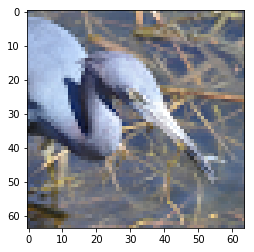

In [29]:
plt.imshow(img)

In [30]:
# Use the pre-trained neural network to extract features from our test image (the same way we did to train the model)
feature_extraction_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
features = feature_extraction_model.predict(images)

# Given the extracted features, make a final prediction using our own model
results = model.predict(features)

# Since we are only testing one image with possible class, we only need to check the first result's first element
single_result = results[0][0]

# Print the result
print("Likelihood that this image contains a dog: {}%".format(int(single_result * 100)))

Likelihood that this image contains a dog: 0%


In [32]:
# Load a dog image file to test, resizing it to 64x64 pixels (as required by this model)
img1 = image.load_img("dog.png", target_size=(64, 64))

# Convert the image to a numpy array
image_array = image.img_to_array(img1)

# Add a forth dimension to the image (since Keras expects a bunch of images, not a single image)
images = np.expand_dims(image_array, axis=0)

# Normalize the data
images = vgg16.preprocess_input(images)

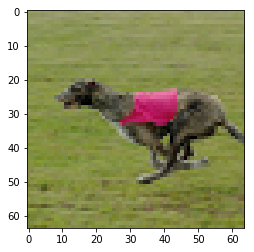

In [33]:
plt.imshow(img1)

In [34]:
# Use the pre-trained neural network to extract features from our test image (the same way we did to train the model)
feature_extraction_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
features = feature_extraction_model.predict(images)

# Given the extracted features, make a final prediction using our own model
results = model.predict(features)

# Since we are only testing one image with possible class, we only need to check the first result's first element
single_result = results[0][0]

# Print the result
print("Likelihood that this image contains a dog: {}%".format(int(single_result * 100)))

Likelihood that this image contains a dog: 100%
